# ✈️ Análisis de Vuelos de Cabotaje e Internacionales desde y hacia Argentina

Este notebook realiza la descarga, limpieza y transformación de los datos de vuelos  desde el portal de datos abiertos de la Secretaría de Turismo. Se generan tablas de rutas únicas y se georreferenciacian localidades para .

In [1]:
import pandas as pd
import requests
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://datos.yvera.gob.ar/dataset/c0e7bc3d-553c-405c-8b32-79282b28ffd5/resource/aab49234-28c9-48ab-a978-a83485139290/download/base_microdatos.csv"
nombre_archivo = "base_microdatos.csv"

response = requests.get(url, verify=False)

with open(nombre_archivo, "wb") as f:
    f.write(response.content)

print("Descarga completa.")

df = pd.read_csv('base_microdatos.csv')

Descarga completa.


## 🔍 Exploración inicial de la base

In [6]:
print("Último índice de tiempo:", max(df.indice_tiempo))
print("Dimensiones:", df.shape)
print(df.info())
print(df.head())
print(df.describe())

Último índice de tiempo: 2025-05-31
Dimensiones: (919498, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919498 entries, 0 to 919497
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   indice_tiempo        919498 non-null  object
 1   clasificacion_vuelo  919498 non-null  object
 2   clase_vuelo          919498 non-null  object
 3   aerolinea            919498 non-null  object
 4   origen_oaci          919498 non-null  object
 5   origen_aeropuerto    919498 non-null  object
 6   origen_localidad     919498 non-null  object
 7   origen_provincia     725646 non-null  object
 8   origen_pais          919498 non-null  object
 9   origen_continente    919497 non-null  object
 10  destino_oaci         919498 non-null  object
 11  destino_aeropuerto   919498 non-null  object
 12  destino_localidad    919498 non-null  object
 13  destino_provincia    724244 non-null  object
 14  destino_pais         9


## 📊 Análisis exploratorio gráfico (EDA)

A continuación se presentan distintos gráficos para analizar la distribución de variables como cantidad de asientos por vuelo, tasa de ocupación y cantidad de pasajeros. Se utilizan boxplots, gráficos de densidad e histogramas con curvas KDE.


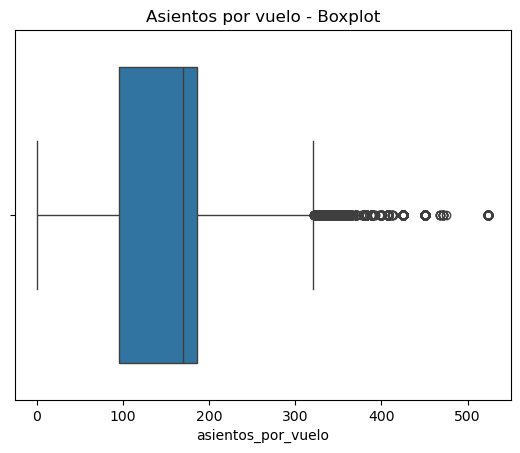

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

#creamos variables para ver si los números son lógicos. Datos sin 0. 
    
df['asientos_por_vuelo'] = df['asientos'] / df['vuelos']
df['ocupacion'] = df['pasajeros'] / df['asientos']

# Boxplot: Asientos por vuelo
sns.boxplot(x=df['asientos_por_vuelo'])
plt.title('Asientos por vuelo - Boxplot')
plt.show()


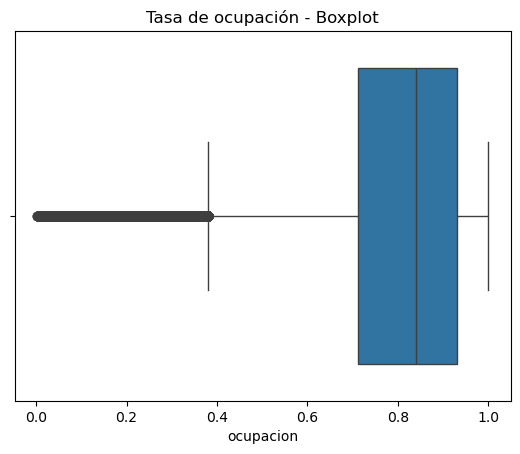

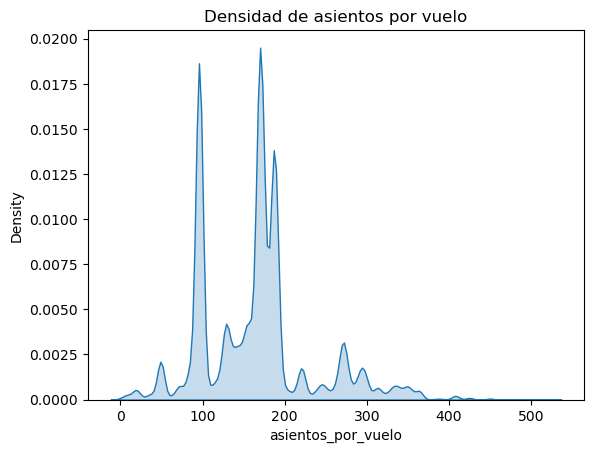

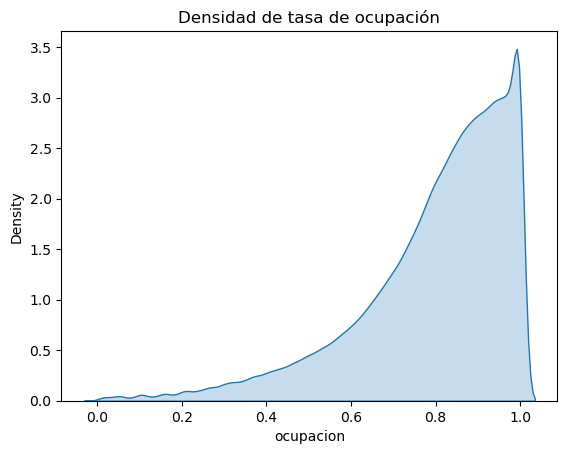

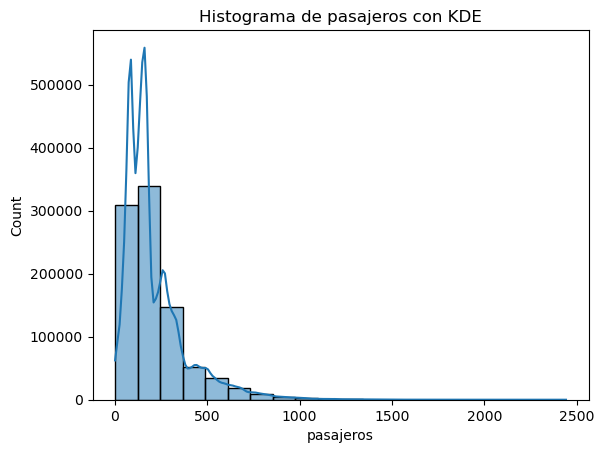

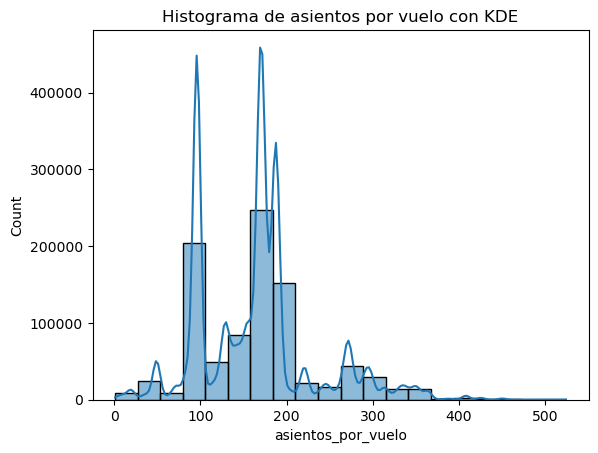

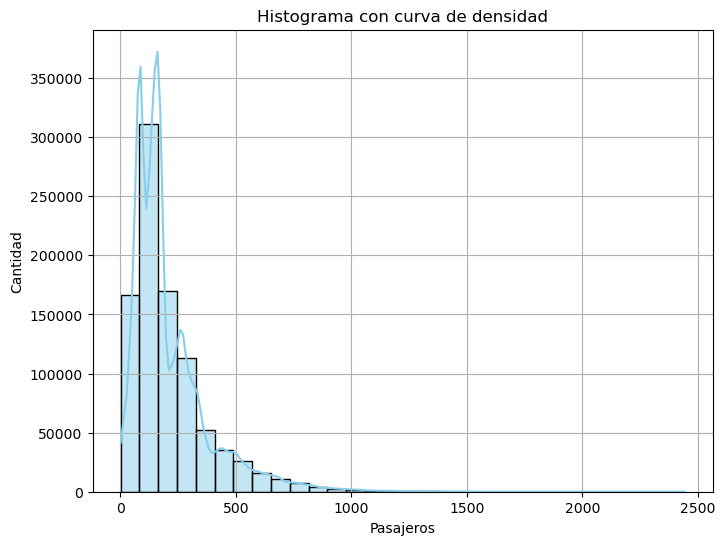

In [14]:

# Boxplot: Tasa de ocupación
sns.boxplot(x=df['ocupacion'])
plt.title('Tasa de ocupación - Boxplot')
plt.show()

# Gráficos de densidad
sns.kdeplot(df['asientos_por_vuelo'].dropna(), fill=True)
plt.title('Densidad de asientos por vuelo')
plt.show()

sns.kdeplot(df['ocupacion'].dropna(), fill=True)
plt.title('Densidad de tasa de ocupación')
plt.show()

# Histogramas con densidad (KDE)
sns.histplot(data=df, x='pasajeros', bins=20, kde=True)
plt.title('Histograma de pasajeros con KDE')
plt.show()

sns.histplot(x=df['asientos_por_vuelo'], bins=20, kde=True)
plt.title('Histograma de asientos por vuelo con KDE')
plt.show()

# Histograma detallado con grilla y etiquetas
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='pasajeros', bins=30, kde=True, color='skyblue', edgecolor='k')
plt.xlabel('Pasajeros')
plt.ylabel('Cantidad')
plt.title('Histograma con curva de densidad')
plt.grid(True)
plt.show()


## 🧹 Corrección de errores en nombres de localidades y continentes

In [15]:
df['origen_localidad'] = df['origen_localidad'].replace({
    'Larnarca': 'Larnaca',
    'Montréal': 'Montreal'
})

df['destino_localidad'] = df['destino_localidad'].replace({
    'Larnarca': 'Larnaca',
    'Montréal': 'Montreal'
})

df['origen_localidad'] = df['origen_localidad'].str.replace(r'(?i)rio de janeiro', 'Río de Janeiro', regex=True)
df['destino_localidad'] = df['destino_localidad'].str.replace(r'(?i)rio de janeiro', 'Río de Janeiro', regex=True)

df['origen_loc_pais'] = df['origen_localidad'] + ' (' + df['origen_pais'] + ')'
df['destino_loc_pais'] = df['destino_localidad'] + ' (' + df['destino_pais'] + ')'

In [16]:
correcciones_continente = {
    'UUEE': 'Europa',
    'TNCC': 'América Central y Caribe'
}

df['origen_continente'] = df.apply(
    lambda row: correcciones_continente.get(row['origen_oaci'], row['origen_continente']),
    axis=1
)

df['destino_continente'] = df.apply(
    lambda row: correcciones_continente.get(row['destino_oaci'], row['destino_continente']),
    axis=1
)

## 🔀 Creo columna de rutas únicas y guardo tabla de vuelos (fct)

In [17]:
def ruta_nombre(row):
    if row['origen_pais'] == 'Argentina' and row['destino_pais'] != 'Argentina':
        return f"{row['origen_loc_pais']} - {row['destino_loc_pais']}"
    elif row['origen_pais'] != 'Argentina' and row['destino_pais'] == 'Argentina':
        return f"{row['destino_loc_pais']} - {row['origen_loc_pais']}"
    else:
        locs = sorted([row['origen_loc_pais'], row['destino_loc_pais']])
        return f"{locs[0]} - {locs[1]}"

df['ruta'] = df.apply(ruta_nombre, axis=1)

df.to_csv("tabla_fct.csv", index=False)

## 🌍 Armado de base de localidades únicas

In [18]:
origenes = df[['origen_localidad', 'origen_pais', 'origen_provincia', 'origen_continente']].drop_duplicates()
origenes.columns = ['localidad', 'pais', 'provincia', 'continente']

destinos = df[['destino_localidad', 'destino_pais', 'destino_provincia', 'destino_continente']].drop_duplicates()
destinos.columns = ['localidad', 'pais', 'provincia', 'continente']

localidades = pd.concat([origenes, destinos]).drop_duplicates().reset_index(drop=True)
localidades['localidad_pais'] = localidades['localidad'] + ' (' + localidades['pais'] + ')'

## 🧭 Detección de nuevas localidades sin coordenadas

In [19]:
loc_con_coordenadas = pd.read_csv('localidades_con_coordenadas.csv')

nuevas_localidades = localidades[~localidades['localidad'].isin(loc_con_coordenadas['localidad'])]

if nuevas_localidades.empty:
    print("✅ No hay localidades nuevas.")
else:
    print("⚠️ Localidades nuevas encontradas: correr script para buscar coordenadas")
    display(nuevas_localidades)

✅ No hay localidades nuevas.


In [21]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Cargar tabla con coordenadas existentes
loc_con_coordenadas = pd.read_csv('localidades_con_coordenadas.csv')

# Verificar si hay nuevas localidades
nuevas_localidades = localidades[~localidades['localidad'].isin(loc_con_coordenadas['localidad'])]

if nuevas_localidades.empty:
    print("✅ No hay localidades nuevas.")
else:
    print("⚠️ Localidades nuevas encontradas:")
    display(nuevas_localidades)
    print("🔎 Buscando coordenadas...")
    
    # Configurar geolocalizador
    geolocator = Nominatim(user_agent="geoapicoord")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    # Función para obtener latitud y longitud
    def obtener_lat_long(localidad, pais):
        try:
            location = geocode(f"{localidad}, {pais}")
            if location:
                return pd.Series([location.latitude, location.longitude])
        except Exception as e:
            print(f"Error con {localidad}, {pais}: {e}")
        return pd.Series([None, None])

    # Aplicar geocodificación
    nuevas_localidades[['lat', 'lon']] = nuevas_localidades.apply(
        lambda row: obtener_lat_long(row['localidad'], row['pais']),
        axis=1
    )

    # Unir con tabla original
    localidades_actualizadas = pd.concat([loc_con_coordenadas, nuevas_localidades], ignore_index=True)
    localidades_actualizadas.to_csv("localidades_con_coordenadas.csv", index=False)
    print("🗺️ Coordenadas agregadas y archivo actualizado.")


✅ No hay localidades nuevas.


## 🗺️ Generación de tabla de rutas únicas con coordenadas y guardado de tabla de rutas (dim)

In [20]:
df_rutas = df[['ruta']].drop_duplicates()
df_rutas[['origen', 'destino']] = df_rutas['ruta'].str.split(' - ', expand=True)

localidad_origen = loc_con_coordenadas.rename(columns={
    'localidad_pais': 'origen',
    'localidad': 'origen_localidad',
    'provincia': 'origen_provincia',
    'pais': 'origen_pais',
    'continente': 'origen_continente',
    'lat': 'origen_lat',
    'lon': 'origen_lon'
})

localidad_destino = loc_con_coordenadas.rename(columns={
    'localidad_pais': 'destino',
    'localidad': 'destino_localidad',
    'provincia': 'destino_provincia',
    'pais': 'destino_pais',
    'continente': 'destino_continente',
    'lat': 'destino_lat',
    'lon': 'destino_lon'
})

df_rutas = df_rutas.merge(localidad_origen, on='origen', how='left')
df_rutas = df_rutas.merge(localidad_destino, on='destino', how='left')

cols_ordenadas = [
    'ruta', 
    'origen', 'origen_localidad', 'origen_pais', 'origen_provincia', 'origen_continente', 'origen_lat', 'origen_lon',
    'destino', 'destino_localidad', 'destino_pais', 'destino_provincia', 'destino_continente', 'destino_lat', 'destino_lon'
]

df_rutas = df_rutas[cols_ordenadas]

df_rutas.rename(columns={
    'origen': 'Origen',
    'destino': 'Destino'
}, inplace=True)

df_rutas.to_csv('tabla_dim.csv', index=False, encoding='utf-8')